# DCGAN on CIFAR-10

In this assignment, you are to train a DCGAN on CIFAR-10. Below you may find the data loader and the generator and discriminator networks. The assignment consists of the following tasks:

**1)**  Compare the two ways to update generator discussed in the original [paper](https://arxiv.org/abs/1406.2661) (page 3, above the figure). The first is two minimise $\mathbb E_z \log (1 - D(G(z))$ and the second is to maximise $\mathbb E_z \log D(G(z))$.

To do this fix a small number of training epochs (around 5) and plot the values of generator and discriminator losses for both cases. How do the two graphs compare? As a sanity check, plot the fake samples at the end of each epoch.

**2)** Train a GAN with the second generator update and a more significant number of training epochs. To track the training progress plot fake samples at the end of each epoch. How do the resulting samples compare with the real data samples visually?

**3)** To estimate the generalization properties of the generator qualitatively, plot interpolations between randomly generated samples. To do this, pick two random noise vectors, connect them with a line and decode the points on the line using the generator.

In [10]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np
from torchvision import transforms
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)



In [11]:
data_folder = './data'
batch_size = 64
image_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

n_channels = 3
n_feature_maps = 64
z_dim = 128

# for the data to be compatible with the DCGAN architecture we will resize it to 64*64
dataset = torchvision.datasets.CIFAR10(
    root=data_folder,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

Files already downloaded and verified


In [0]:
def get_dcgan_generator(z_dim, n_feature_maps=64, n_channels=3):
    layers = [
        nn.ConvTranspose2d(z_dim, n_feature_maps * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_feature_maps * 8),
        nn.ReLU(),
        # n_features * 8 x 4 x 4
        nn.ConvTranspose2d(n_feature_maps * 8, n_feature_maps * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_feature_maps * 4),
        nn.ReLU(),
        # n_features * 4 x 8 x 8
        nn.ConvTranspose2d(n_feature_maps * 4, n_feature_maps * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_feature_maps * 2),
        nn.ReLU(),
        # n_features * 2 x 16 x 16
        nn.ConvTranspose2d(n_feature_maps * 2, n_feature_maps, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_feature_maps),
        nn.ReLU(),
        # n_features x 32 x 32
        nn.ConvTranspose2d(n_feature_maps, n_channels, 4, 2, 1, bias=False),
        nn.Tanh()]
        # n_channels x 64 x 64
    return nn.Sequential(*layers)
    
def get_dcgan_discriminator(n_feature_maps=64, n_channels=3):
    layers = [
        nn.Conv2d(n_channels, n_feature_maps, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2),
        # n_feature_maps x 32 x 32
        nn.Conv2d(n_feature_maps, n_feature_maps * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_feature_maps * 2),
        nn.LeakyReLU(0.2),
        # n_feature_maps * 2 x 16 x 16
        nn.Conv2d(n_feature_maps * 2, n_feature_maps * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_feature_maps * 4),
        nn.LeakyReLU(0.2),
        # n_feature_maps * 4 x 8 x 8
        nn.Conv2d(n_feature_maps * 4, n_feature_maps * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_feature_maps * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # n_feature_maps * 8 x 4 x 4
        nn.Conv2d(n_feature_maps * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()]
    return nn.Sequential(*layers)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [13]:
generator = get_dcgan_generator(z_dim).to(device)
generator.apply(weights_init)
discriminator = get_dcgan_discriminator().to(device)
discriminator.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002,
                         betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(),
                         lr=0.0002, betas=(0.5, 0.999))

In [0]:
real_label = 1
fake_label = 0

In [0]:
n_epochs = 5
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        # update discriminator
        discriminator.zero_grad()
        real_data = data[0].to(device)
        d_real_scores = discriminator(real_data)
        
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_samples = generator(noise)
        d_fake_scores = discriminator(fake_samples)
        # TODO
        
        # update generator
        generator.zero_grad()
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_samples = generator(noise)
        d_fake_scores = discriminator(fake_samples)
        # TODO

In [0]:
def train(generator_label, plt_generated = False, n_epochs=5):
  lr = 0.0002
  beta1 = 0.5
  criterion = nn.BCELoss()
  optimizerD = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
  
  G_losses = []
  D_losses = []
  
  for epoch in range(n_epochs):
      for i, data in enumerate(dataloader, 0):
          # update discriminator
          discriminator.zero_grad()
          real_data = data[0].to(device)

          #real
          b_size = real_data.size(0)
          label = torch.full((b_size,), real_label, device=device)
          d_real_scores = discriminator(real_data)
          errD_real = criterion(d_real_scores, label)
          errD_real.backward()
          #end real 

          #fake
          noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
          label = torch.full((batch_size,), fake_label, device=device)
          fake_samples = generator(noise)
          d_fake_scores = discriminator(fake_samples.detach()).view(-1)
          errD_fake = criterion(d_fake_scores, label)
          errD_fake.backward()
          errD = errD_real + errD_fake

          #end fake
          D_losses.append(errD.item())

          optimizerD.step()





          # TODO

          # update generator
          generator.zero_grad()
          label = torch.full((batch_size,), generator_label, device=device)



          noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
          fake_samples = generator(noise)
          d_fake_scores = discriminator(fake_samples).view(-1)
          errG = criterion(d_fake_scores, label)
          errG.backward()
          optimizerG.step()
          G_losses.append(errG.item())

          
      if plt_generated:
      
        with torch.no_grad():
          img_list= []
          fake = generator(noise).detach().cpu()
          img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
          fig = plt.figure(figsize=(8,8))
          plt.axis("off")
          ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
          ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

          HTML(ani.to_jshtml())
        
          
  return D_losses, G_losses

          # TODO
  
  

In [0]:
# def train(generator_label, plt_generated = False, n_epochs=5):
#   lr = 0.0002
#   beta1 = 0.5
#   criterion = nn.BCELoss()
#   optimizerD = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
#   optimizerG = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
#   real_label = 1
#   fake_label = 0
#   G_losses = []
#   D_losses = []
  
#   for epoch in range(n_epochs):
#     #print(epoch)
#     for i, data in enumerate(dataloader, 0):
#         # update discriminator
#         discriminator.zero_grad()
#         real_data = data[0].to(device)
#         d_real_scores = discriminator(real_data).view(-1)

#         noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
#         fake_samples = generator(noise)
#         d_fake_scores = discriminator(fake_samples.detach()).view(-1)
#         # TODO
#         label = torch.full((d_real_scores.shape[0],), real_label, device=device)
#         errD_real = criterion(d_real_scores, label)
#         errD_real.backward()

#         #fake
#         #label.fill_(0)
#         label = torch.full((d_fake_scores.shape[0],), fake_label, device=device)

#         errD_fake = criterion(d_fake_scores, label)
#         errD_fake.backward()
#         optimizerD.step()
#         errD = errD_real + errD_fake
#         D_losses.append(errD.item())
#         #gabi de

#         # update generator
#         generator.zero_grad()
#         noise = torch.randn(batch_size, z_dim, 1, 1, device=device)
#         fake_samples = generator(noise)
#         d_fake_scores = discriminator(fake_samples).view(-1)

        
#         label = torch.full((d_fake_scores.shape[0],), generator_label, device=device)
#         #label.fill_(real_label)
#         errG = criterion(d_fake_scores, label)
#         errG.backward()
#         optimizerG.step()
#         G_losses.append(errG.item())
#         # TODO

#         #gabi general
        
        
#         #gabi general
      
#     if plt_generated:
      
#       with torch.no_grad():
#         img_list= []
#         fake = generator(noise).detach().cpu()
#         img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
#         fig = plt.figure(figsize=(8,8))
#         plt.axis("off")
#         ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
#         ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

#         HTML(ani.to_jshtml())
        
      
#       #plt.figure(figsize=(8, 8))
#       #plt.axis("off")
#       #plt.title("Training Images")
#       #plt.imshow(np.transpose(vutils.make_grid(fake_samples.detach()[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))


#         #

#   return   D_losses, G_losses
  
  
  

0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


2
3
4


In [21]:
d_losses_1, g_losses_1 = train(real_label)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


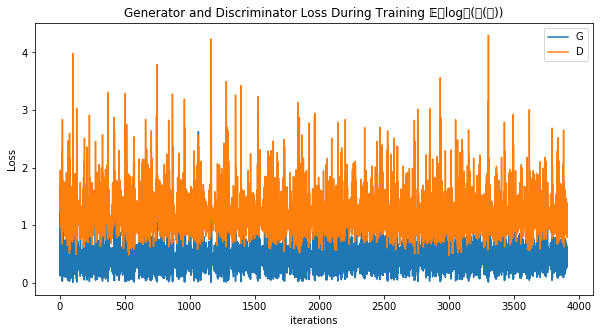

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training 𝔼𝑧log𝐷(𝐺(𝑧))")
plt.plot(g_losses_1,label="G")
plt.plot(d_losses_1,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [28]:
d_losses_0, g_losses_0 = train(fake_label)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


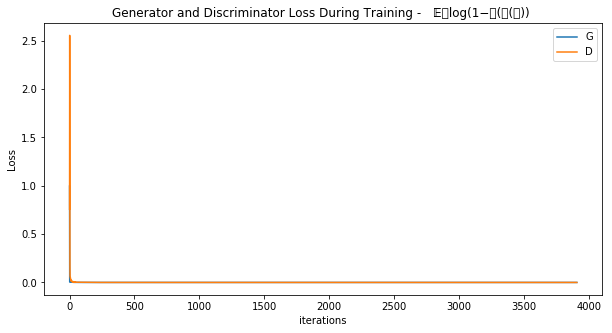

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training -   𝔼𝑧log(1−𝐷(𝐺(𝑧)) ")
plt.plot(g_losses_0,label="G")
plt.plot(d_losses_0,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
d1, r1 = train(real_label, plt_generated = True, n_epochs=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [0]:
d1 == r1

False

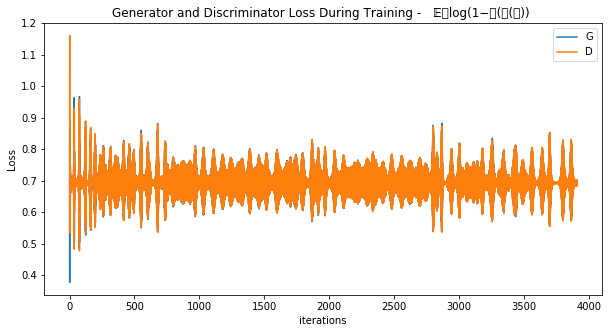

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training -   𝔼𝑧log(1−𝐷(𝐺(𝑧)) ")
plt.plot(r1,label="G")
plt.plot(d1,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()